# 1D Finite Element Solver
We aim to solve a differential equation for a 1 dimensional case with the form
$$
- \frac{\partial}{\partial x} \alpha(x) \cdot \frac{\partial \Phi (x)}{\partial x} + \beta(x) \cdot \Phi (x)=f (x)
$$
with the galerkin method. Details can be found in the [lecture notes]("G:\My Drive\HKA EITB\Semester 6\Methoden der Feldberechnung\GalerkinVerfahren.pdf"), page 13.

To do so, we split the domain of the function given as boundary values in smaller parts and solve a linear equations system comprising all subdomains.


## Exercise
$$
-\frac{d}{d x}\left(x^2 \frac{d \Phi}{d x}\right)+x \Phi=-x^3
$$
The boundary values are $\Phi(x=1)=2, \Phi(x=2)=6$. The knots of the subdomain are the following:
$$
[1.75, 2, 1.25, 1, 1.5]
$$

In [130]:
import numpy as np
import random
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_theme()

## Express the given values and functions

In [131]:
def alpha(x):
    "given in the diff. eq."
    return np.square(x)

def beta(x):
    "given in the diff. eq."
    return x

def right_hand_side(x):
    "given in the diff. eq."
    return - np.power(x, 3)

# given from the boundary conditions:
LOWER_BOUND = 1
UPPER_BOUND = 2

NUMBER_OF_DOMAINS = 5

In [132]:
# NUMBER_OF_DOMAINS increments from LOWER_BOUND to UPPER_BOUND in random order
domain_knots = np.array([1.75, 2, 1.25, 1, 1.5], dtype=float)
print(domain_knots)

[1.75 2.   1.25 1.   1.5 ]


In [133]:
boundary = {
    "Lower Bound": {"x Value": 1, "x Index": np.where(domain_knots == 1)[0][0], "Phi": 2.0},
    "Upper Bound": {"x Value": 2, "x Index": np.where(domain_knots == 2)[0][0], "Phi": 6.0}
}
print(boundary)

{'Lower Bound': {'x Value': 1, 'x Index': np.int64(3), 'Phi': 2.0}, 'Upper Bound': {'x Value': 2, 'x Index': np.int64(1), 'Phi': 6.0}}


## Create the subdomain index list

In [134]:
def get_edge_indices(knots: np.array) -> np.array:
    "Returns index pairs representing element edges based on sorted knots."
    sorted_knots = np.sort(knots)
    knot_index_by_value = {value: index for index, value in enumerate(knots)}

    indices = []
    for index in range(len(sorted_knots) -1):
        start_index = knot_index_by_value[sorted_knots[index]]
        stop_index = knot_index_by_value[sorted_knots[index +1]]
        indices.append([start_index, stop_index])

    indices = np.array(indices, dtype=int)
    return indices

domain_indices = get_edge_indices(domain_knots)
domain_indices

array([[3, 2],
       [2, 4],
       [4, 0],
       [0, 1]])

## calculate matrix values
Calculate matrix values according to the following equations:
$$
L_E = x_2 -x_1
$$

$$
x_M = \frac{x_2 + x_1}{2}
$$

$$
K_{i,j} = \frac{\alpha(x_M)}{L_E} \begin{pmatrix} 1 & -1 \\ -1 & 1 \end{pmatrix} + \frac{L_E \cdot \beta(x_M)}{6} \begin{pmatrix} 2 & 1 \\ 1 & 2 \end{pmatrix}
$$

$$
D_j = \frac{L_E \cdot f(x_M)}{2} \begin{pmatrix} 1& 1 \end{pmatrix}
$$

In [135]:
def get_element_coefficients(midpoint, edge_length, alpha, beta):
    matrix1 = np.array([1, -1, -1, 1]).reshape(2,2)
    matrix2 = np.array([2, 1, 1, 2]).reshape(2,2)

    return alpha(midpoint) / edge_length * matrix1 + edge_length * beta(midpoint) / 6 * matrix2

def get_element_rhs(midpoint, edge_length, right_hand_side):
    matrix = np.array([1,1])
    return edge_length / 2 * right_hand_side(midpoint) * matrix

def assemble_element(start, end):
    midpoint = (start + end) / 2
    element_length = abs(end - start)
    element_coefficients = get_element_coefficients(midpoint, element_length, alpha, beta)
    element_rhs = get_element_rhs(midpoint, element_length, right_hand_side)
    return element_coefficients, element_rhs

In [136]:
elements = []
for start_index, stop_index in domain_indices:
    start = domain_knots[start_index]
    end = domain_knots[stop_index]
    element_coefficients, element_rhs = assemble_element(start, end)
    elements.append({
        'Start Index': start_index,
        'Stop Index': stop_index,
        # 'Start Value': start,
        # 'Stop Value': end,
        'Coefficients': element_coefficients,
        'Right Hand Side': element_rhs
    })

elements

[{'Start Index': np.int64(3),
  'Stop Index': np.int64(2),
  'Coefficients': array([[ 5.15625 , -5.015625],
         [-5.015625,  5.15625 ]]),
  'Right Hand Side': array([-0.17797852, -0.17797852])},
 {'Start Index': np.int64(2),
  'Stop Index': np.int64(4),
  'Coefficients': array([[ 7.67708333, -7.50520833],
         [-7.50520833,  7.67708333]]),
  'Right Hand Side': array([-0.32495117, -0.32495117])},
 {'Start Index': np.int64(4),
  'Stop Index': np.int64(0),
  'Coefficients': array([[ 10.69791667, -10.49479167],
         [-10.49479167,  10.69791667]]),
  'Right Hand Side': array([-0.53637695, -0.53637695])},
 {'Start Index': np.int64(0),
  'Stop Index': np.int64(1),
  'Coefficients': array([[ 14.21875 , -13.984375],
         [-13.984375,  14.21875 ]]),
  'Right Hand Side': array([-0.82397461, -0.82397461])}]

## Add Element Values to the global linear equation system

## THen Use the bondary conditions on the matrices

In [137]:
coefficients_matrix = np.zeros(shape=(5,5))

right_hand_side_matrix = np.zeros(shape=(5,1))
for element in elements:
    coefficients_matrix[element["Start Index"]][element["Start Index"]] += element["Coefficients"][0][0]
    coefficients_matrix[element["Start Index"]][element["Stop Index"]] += element["Coefficients"][0][1]
    coefficients_matrix[element["Stop Index"]][element["Start Index"]] += element["Coefficients"][1][0]
    coefficients_matrix[element["Stop Index"]][element["Stop Index"]] += element["Coefficients"][1][1]

    right_hand_side_matrix[element["Start Index"]] += element["Right Hand Side"][0]
    right_hand_side_matrix[element["Stop Index"]] += element["Right Hand Side"][1]

print("Full linear equation system:")
print(coefficients_matrix)
print(right_hand_side_matrix)

# remove row from coefficients_matrix: 
coefficients_matrix = np.delete(coefficients_matrix, boundary["Lower Bound"]["x Index"], axis=0)
coefficients_matrix = np.delete(coefficients_matrix, boundary["Upper Bound"]["x Index"], axis=0)

# remove row from right_hand_side_matrix
right_hand_side_matrix = np.delete(right_hand_side_matrix, boundary["Lower Bound"]["x Index"], axis=0)
right_hand_side_matrix = np.delete(right_hand_side_matrix, boundary["Upper Bound"]["x Index"], axis=0)
coefficients_matrix[: ,boundary["Upper Bound"]["x Index"]]

right_hand_side_matrix = right_hand_side_matrix - boundary["Upper Bound"]["Phi"] * coefficients_matrix[: ,boundary["Upper Bound"]["x Index"]].reshape(3,1) - boundary["Lower Bound"]["Phi"] * coefficients_matrix[: ,boundary["Lower Bound"]["x Index"]].reshape(3,1)

# remove column from coefficients_matrix: 
coefficients_matrix = np.delete(coefficients_matrix, boundary["Lower Bound"]["x Index"], axis=1)
coefficients_matrix = np.delete(coefficients_matrix, boundary["Upper Bound"]["x Index"], axis=1)

print("Reduced Matrices:")
print(coefficients_matrix)
print(right_hand_side_matrix)

Full linear equation system:
[[ 24.91666667 -13.984375     0.           0.         -10.49479167]
 [-13.984375    14.21875      0.           0.           0.        ]
 [  0.           0.          12.83333333  -5.015625    -7.50520833]
 [  0.           0.          -5.015625     5.15625      0.        ]
 [-10.49479167   0.          -7.50520833   0.          18.375     ]]
[[-1.36035156]
 [-0.82397461]
 [-0.50292969]
 [-0.17797852]
 [-0.86132812]]
Reduced Matrices:
[[ 24.91666667   0.         -10.49479167]
 [  0.          12.83333333  -7.50520833]
 [-10.49479167  -7.50520833  18.375     ]]
[[82.54589844]
 [ 9.52832031]
 [-0.86132812]]


## Solve the completed linear equations system

In [138]:
reduced_solutions = np.linalg.solve(coefficients_matrix, right_hand_side_matrix)

# manually update the index values. TO DO: automate this part!
reduced_solutions= np.insert(reduced_solutions, boundary["Lower Bound"]["x Index"] -1, boundary["Lower Bound"]["Phi"])  

reduced_solutions= np.insert(reduced_solutions, boundary["Upper Bound"]["x Index"], boundary["Upper Bound"]["Phi"])   

print(reduced_solutions)

[5.05126211 6.         3.1561756  2.         4.12725827]


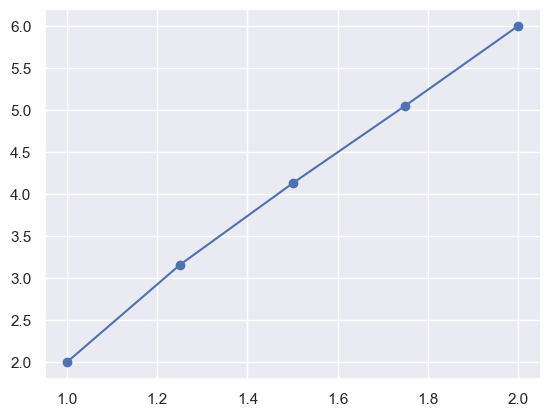

In [ ]:
# Question: how do i sort the solutions vector?
x = np.linspace(LOWER_BOUND, UPPER_BOUND, NUMBER_OF_DOMAINS)
plt.scatter(x, np.sort(reduced_solutions))
plt.plot(x, np.sort(reduced_solutions))
plt.xlabel("x")
plt.ylabel(r"\Phi (x)")
plt.title(f"DGL Solution with {NUMBER_OF_DOMAINS} subdomains")

plt.tight_layout()
plt.show()